In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from zonolayer import Zonolayer

### Dataset
1. Load dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength)
2. Scale and Intervalise the data, intervalisation method comes from [(Tretiak et al., 2023)](https://www.sciencedirect.com/science/article/pii/S0893608023000680)

In [2]:
concrete = fetch_ucirepo(id=165) 
df = pd.concat([concrete.data.features, concrete.data.targets], axis=1)
y = df["Concrete compressive strength"].values

def intervalise_cc_strength(y):
    n = len(y)
    Delta = np.abs(np.random.normal(loc=2, scale=1, size=n))
    b = np.random.uniform(-1, 1, size=n)
    m = y + b * Delta
    y_lower = m - Delta
    y_upper = m + Delta
    return pd.DataFrame({
        "y": y,
        "y_lower": y_lower,
        "y_upper": y_upper,
        "Delta": Delta,
        "b": b
    })

intervals = intervalise_cc_strength(y)
print("Interval Statistics:")
print(intervals.describe())

# Prepare features and targets
X = concrete.data.features.values
y_true = intervals["y"].values
y_lower = intervals["y_lower"].values
y_upper = intervals["y_upper"].values

# Train-test split
X_train, X_test, y_train, y_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(
    X, y_true, y_lower, y_upper, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train_scaled)
X_test_t = torch.FloatTensor(X_test_scaled)

print(f"\nTraining samples: {len(X_train_t)}")
print(f"Test samples: {len(X_test_t)}")
print(f"Input features: {X_train_t.shape[1]}")

Interval Statistics:
                 y      y_lower      y_upper        Delta            b
count  1030.000000  1030.000000  1030.000000  1030.000000  1030.000000
mean     35.817961    33.845693    37.828611     1.991459     0.015447
std      16.705742    16.754460    16.714027     0.963442     0.582252
min       2.330000     0.278403     2.688708     0.050788    -0.999233
25%      23.710000    21.557107    25.217641     1.291430    -0.489893
50%      34.445000    32.604765    36.600552     1.957166     0.031684
75%      46.135000    44.246630    47.936664     2.646903     0.529684
max      82.600000    80.111997    85.367635     5.904209     0.999641

Training samples: 824
Test samples: 206
Input features: 8


### Neural Network
Standard Nueral Network trained on the midpoints of the target Y-intervals

In [3]:
class CentreNet(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dims=[16, 16]):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.Tanh()
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        self.latent_layer = nn.Linear(prev_dim, latent_dim)
        self.output_layer = nn.Linear(latent_dim, 1)
        
    def forward(self, x, return_latent=False):
        h = self.encoder(x)
        latent = self.latent_layer(h)
        output = self.output_layer(latent)
        
        if return_latent:
            return output, latent
        return output


input_dim = X_train_t.shape[1]
net = CentreNet(input_dim=input_dim)

# Use interval centres as training targets
y_centre_train = (y_lower_train + y_upper_train) / 2
y_centre_train_t = torch.FloatTensor(y_centre_train).reshape(-1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

print("\nTraining neural network...")
epochs = 7000
losses = []

for epoch in range(epochs):
    net.train()
    optimizer.zero_grad()
    
    outputs = net(X_train_t)
    loss = criterion(outputs, y_centre_train_t)
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Training neural network...
Epoch [50/7000], Loss: 1492.5618
Epoch [100/7000], Loss: 1239.0310
Epoch [150/7000], Loss: 688.0150
Epoch [200/7000], Loss: 303.5655
Epoch [250/7000], Loss: 165.1882
Epoch [300/7000], Loss: 119.0735
Epoch [350/7000], Loss: 100.0034
Epoch [400/7000], Loss: 91.5176
Epoch [450/7000], Loss: 86.2083
Epoch [500/7000], Loss: 81.2875
Epoch [550/7000], Loss: 76.8289
Epoch [600/7000], Loss: 71.8220
Epoch [650/7000], Loss: 65.2053
Epoch [700/7000], Loss: 58.0914
Epoch [750/7000], Loss: 50.0340
Epoch [800/7000], Loss: 44.2956
Epoch [850/7000], Loss: 40.3299
Epoch [900/7000], Loss: 37.1199
Epoch [950/7000], Loss: 34.3143
Epoch [1000/7000], Loss: 31.9221
Epoch [1050/7000], Loss: 30.0668
Epoch [1100/7000], Loss: 28.7112
Epoch [1150/7000], Loss: 27.6873
Epoch [1200/7000], Loss: 26.8570
Epoch [1250/7000], Loss: 26.1382
Epoch [1300/7000], Loss: 25.4880
Epoch [1350/7000], Loss: 24.8848
Epoch [1400/7000], Loss: 24.3184
Epoch [1450/7000], Loss: 23.7851
Epoch [1500/7000], Loss: 2

     pcost       dcost       gap    pres   dres   k/t
 0: -1.0658e-14 -6.2427e-12  7e+04  5e-01  2e+03  1e+00
 1:  3.9935e+01  4.2445e+01  9e+03  6e-02  2e+02  3e+00
 2:  3.5551e+01  3.6034e+01  2e+03  2e-02  5e+01  5e-01
 3:  3.3075e+01  3.3362e+01  1e+03  9e-03  3e+01  3e-01
 4:  3.3329e+01  3.3445e+01  4e+02  4e-03  1e+01  1e-01
 5:  3.2610e+01  3.2720e+01  4e+02  3e-03  1e+01  1e-01
 6:  2.8571e+01  2.8597e+01  9e+01  1e-03  3e+00  3e-02
 7:  2.6617e+01  2.6634e+01  6e+01  7e-04  2e+00  2e-02
 8:  2.7544e+01  2.7562e+01  6e+01  7e-04  2e+00  2e-02
 9:  2.6684e+01  2.6695e+01  4e+01  4e-04  1e+00  1e-02
10:  2.6279e+01  2.6289e+01  3e+01  4e-04  1e+00  1e-02
11:  2.6303e+01  2.6311e+01  2e+01  3e-04  9e-01  8e-03
12:  2.5741e+01  2.5744e+01  1e+01  1e-04  4e-01  3e-03
13:  2.5619e+01  2.5621e+01  7e+00  8e-05  3e-01  2e-03
14:  2.5471e+01  2.5472e+01  2e+00  3e-05  9e-02  7e-04
15:  2.5469e+01  2.5470e+01  2e+00  2e-05  8e-02  6e-04
16:  2.5427e+01  2.5427e+01  6e-01  7e-06  2e-02  

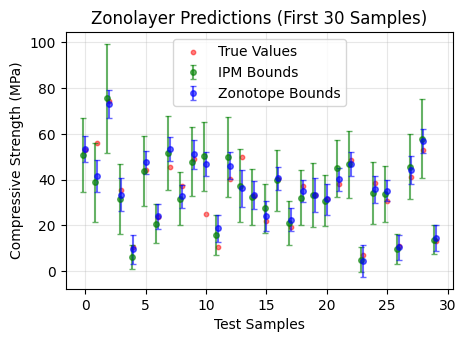

In [4]:
zl = Zonolayer(net, lambda_reg=1e-6, alpha=0.05)
results, ipm_upper, ipm_lower = zl.compute(
    x_train=X_train_t,
    x_test=X_test_t,
    y_lower=y_lower_train,
    y_upper=y_upper_train,
    ipm=True
)

# Extract results
y_centre_pred = results["pred_centre"].flatten()
y_lower_zono = results["y_lower_pred"].flatten()
y_upper_zono = results["y_upper_pred"].flatten()
pi_lower = results["pi_lower"].flatten()
pi_upper = results["pi_upper"].flatten()


fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot Zonolayer predictions as error bars
ax3 = fig.add_subplot(gs[1, 1])
test_indices_plot = np.arange(min(30, len(y_centre_pred)))  # First 100 test samples

y_centre_pred_plot = y_centre_pred[test_indices_plot]
y_lower_zono_plot = y_lower_zono[test_indices_plot]
y_upper_zono_plot = y_upper_zono[test_indices_plot]

ipm_lower_plot = ipm_lower.flatten()[test_indices_plot]
ipm_upper_plot = ipm_upper.flatten()[test_indices_plot]
ipm_centre_plot = (ipm_lower_plot + ipm_upper_plot) / 2

offset = 0.15
ax3.errorbar(
    test_indices_plot - offset,
    ipm_centre_plot,
    yerr=[ipm_centre_plot - ipm_lower_plot, 
          ipm_upper_plot - ipm_centre_plot],
    fmt='o', markersize=4, alpha=0.6, capsize=2, color='green', label='IPM Bounds'
)

ax3.errorbar(
    test_indices_plot,
    y_centre_pred_plot,
    yerr=[y_centre_pred_plot - y_lower_zono_plot, 
          y_upper_zono_plot - y_centre_pred_plot],
    fmt='o', markersize=4, alpha=0.6, capsize=2, color='blue', label='Zonotope Bounds'
)
ax3.scatter(test_indices_plot, y_test[test_indices_plot], color='red', s=10, alpha=0.5, label='True Values')

ax3.set_xlabel('Test Samples')
ax3.set_ylabel('Compressive Strength (MPa)')
ax3.set_title('Zonolayer Predictions (First 30 Samples)')
ax3.legend()
ax3.grid(True, alpha=0.3)



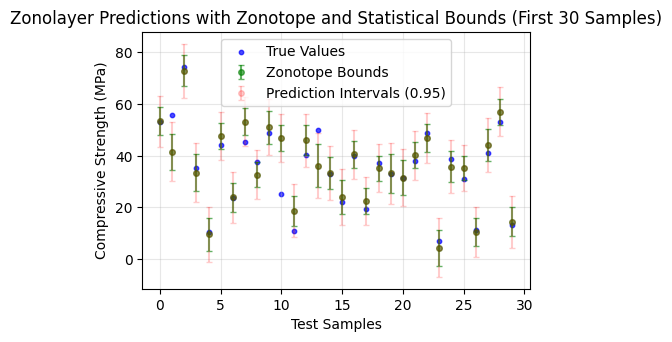

In [5]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax3 = fig.add_subplot(gs[1, 1])

# Select first 30 test samples
test_indices_plot = np.arange(min(30, len(y_centre_pred)))

# Slice predictions and bounds
y_centre_plot = y_centre_pred[test_indices_plot]
y_lower_zono_plot = y_lower_zono[test_indices_plot]
y_upper_zono_plot = y_upper_zono[test_indices_plot]
pi_lower_plot = pi_lower[test_indices_plot]
pi_upper_plot = pi_upper[test_indices_plot]
y_true_plot = y_test[test_indices_plot]

# Plot Zonotope bounds (blue error bars)
ax3.errorbar(
    test_indices_plot,
    y_centre_plot,
    yerr=[y_centre_plot - y_lower_zono_plot, y_upper_zono_plot - y_centre_plot],
    fmt='o', markersize=4, alpha=0.6, capsize=2, color='green', label='Zonotope Bounds'
)

# Plot Statistical Prediction Intervals (green error bars)
ax3.errorbar(
    test_indices_plot,
    y_centre_plot,
    yerr=[y_centre_plot - pi_lower_plot, pi_upper_plot - y_centre_plot],
    fmt='o', markersize=4, alpha=0.2, capsize=2, color='red', label='Prediction Intervals (0.95)'
)

# Scatter true values (red)
ax3.scatter(test_indices_plot, y_true_plot, color='blue', s=10, alpha=0.7, label='True Values')

# Labels and grid
ax3.set_xlabel('Test Samples')
ax3.set_ylabel('Compressive Strength (MPa)')
ax3.set_title('Zonolayer Predictions with Zonotope and Statistical Bounds (First 30 Samples)')
ax3.legend()
ax3.grid(True, alpha=0.3)
